# Avanced House Prices

## Workflow to be performed
- Importa data and libraries
- Handle nulls (in a simple way)
- Encode variables / transform
- Feature Selection
  - Filter methods: null percentage, univariate statistics, mutual information
  - Wrapper methods: random forests
- Train models
- Select models
- Predict values and submit responses

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv("./inputs/train.csv")
test_df = pd.read_csv("./inputs/test.csv")

train_df.shape, test_df.shape

((1460, 81), (1459, 80))

In [3]:
X_train = train_df.drop(labels=["Id","SalePrice"], axis=1)
X_test = test_df.drop(labels=["Id"], axis=1)
y_train = np.log(train_df["SalePrice"])

In [4]:
X_train.shape, y_train.shape, X_test.shape

((1460, 79), (1460,), (1459, 79))

In [5]:
# Identifying nulls and data types
(X_train.isnull().sum() / X_train.shape[0]).sort_values(ascending=False).head(10)

PoolQC         0.995205
MiscFeature    0.963014
Alley          0.937671
Fence          0.807534
FireplaceQu    0.472603
LotFrontage    0.177397
GarageType     0.055479
GarageYrBlt    0.055479
GarageQual     0.055479
GarageCond     0.055479
dtype: float64

In [6]:
(X_test.isnull().sum() / X_test.shape[0]).sort_values(ascending=False).head(10)

PoolQC          0.997944
MiscFeature     0.965045
Alley           0.926662
Fence           0.801234
FireplaceQu     0.500343
LotFrontage     0.155586
GarageYrBlt     0.053461
GarageFinish    0.053461
GarageQual      0.053461
GarageCond      0.053461
dtype: float64

In [7]:
# Drop features with more than 30% instance values null
def drop_features_with_nulls(dataframe, threshold: float):
    df = dataframe.copy()
    features_to_drop = df.columns[(df.isnull().sum() / df.shape[0]) > threshold]
    return df.drop(labels=features_to_drop, axis=1)

In [8]:
X_train = drop_features_with_nulls(X_train, 0.3)
X_test = drop_features_with_nulls(X_test, 0.3)

In [9]:
print(X_train.shape)
print(X_test.shape)

(1460, 74)
(1459, 74)


In [10]:
# Check column types to handle other nulls properly
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = X_train.select_dtypes(include=numerics).columns
non_numeric_columns = X_train.select_dtypes(exclude=numerics).columns

numeric_null_cols_from_train = X_train.columns[(X_train.isnull().sum() > 0) & (X_train.columns.isin(numeric_columns))]
numeric_null_cols_from_test = X_test.columns[(X_test.isnull().sum() > 0) & (X_test.columns.isin(numeric_columns))]

null_numeric_columns = list(set(numeric_null_cols_from_train).union(numeric_null_cols_from_test))

In [11]:
X_train[null_numeric_columns].isnull().sum().sort_values(ascending=False)

LotFrontage     259
GarageYrBlt      81
MasVnrArea        8
TotalBsmtSF       0
GarageCars        0
BsmtFullBath      0
BsmtFinSF2        0
BsmtHalfBath      0
BsmtUnfSF         0
GarageArea        0
BsmtFinSF1        0
dtype: int64

In [12]:
X_test[null_numeric_columns].isnull().sum().sort_values(ascending=False)

LotFrontage     227
GarageYrBlt      78
MasVnrArea       15
BsmtFullBath      2
BsmtHalfBath      2
TotalBsmtSF       1
GarageCars        1
BsmtFinSF2        1
BsmtUnfSF         1
GarageArea        1
BsmtFinSF1        1
dtype: int64

array([[<Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': 'GarageCars'}>],
       [<Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'GarageYrBlt'}>],
       [<Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>],
       [<Axes: title={'center': 'GarageArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>, <Axes: >]], dtype=object)

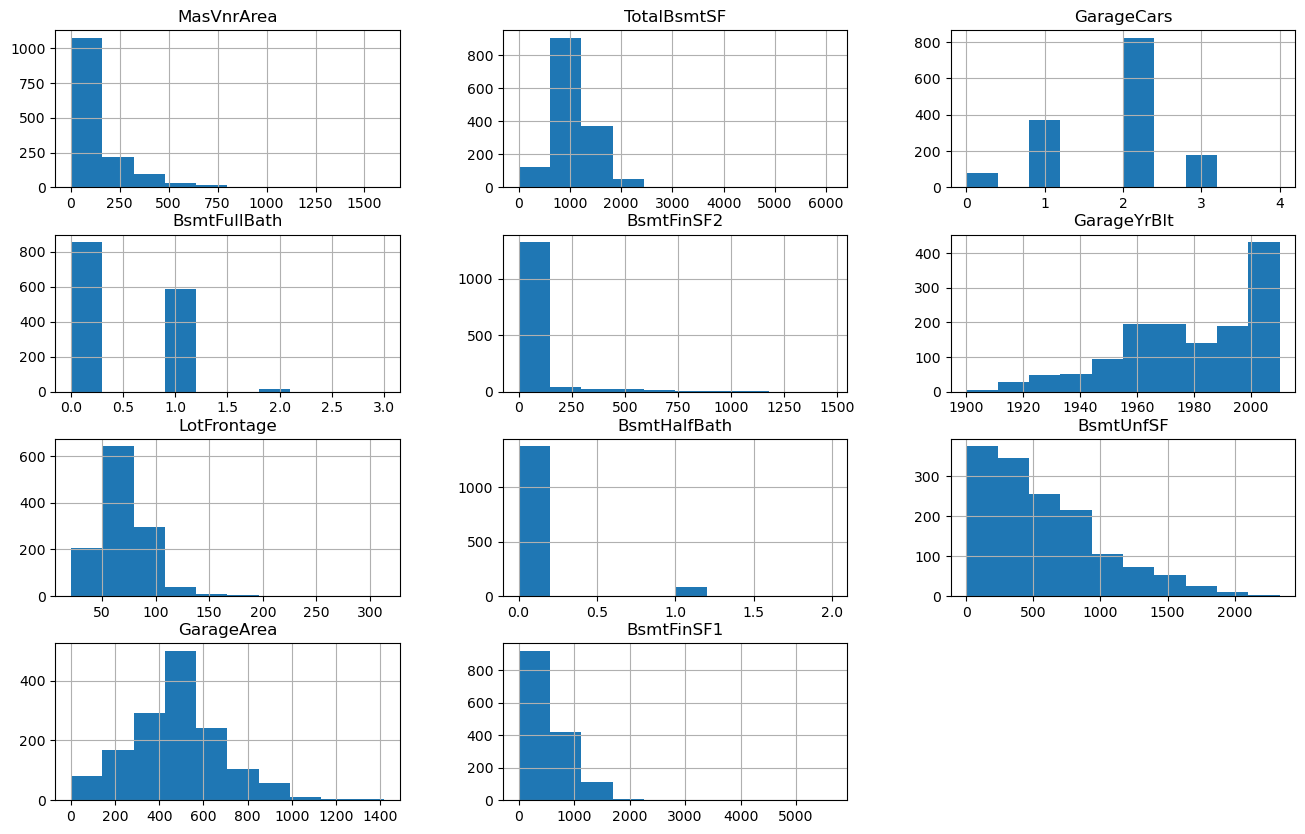

In [13]:
X_train[null_numeric_columns].hist(figsize=(16,10))

In [14]:
X_train[null_numeric_columns].median()

MasVnrArea         0.0
TotalBsmtSF      991.5
GarageCars         2.0
BsmtFullBath       0.0
BsmtFinSF2         0.0
GarageYrBlt     1980.0
LotFrontage       69.0
BsmtHalfBath       0.0
BsmtUnfSF        477.5
GarageArea       480.0
BsmtFinSF1       383.5
dtype: float64

In [15]:
X_test[null_numeric_columns].median()

MasVnrArea         0.0
TotalBsmtSF      988.0
GarageCars         2.0
BsmtFullBath       0.0
BsmtFinSF2         0.0
GarageYrBlt     1979.0
LotFrontage       67.0
BsmtHalfBath       0.0
BsmtUnfSF        460.0
GarageArea       480.0
BsmtFinSF1       350.5
dtype: float64

In [16]:
# Decided to fill numeric values with medians
def fillna_medians(dataframe, features):
    df = dataframe.copy()
    df[features] = df[features].apply(lambda series: series.fillna(series.median()))
    return df

In [17]:
X_train = X_train.pipe(fillna_medians, null_numeric_columns)
X_test = X_test.pipe(fillna_medians, null_numeric_columns)

In [18]:
categ_null_cols_from_train = X_train.columns[(X_train.isnull().sum() > 0) & (~X_train.columns.isin(numeric_columns))]
categ_null_cols_from_test = X_test.columns[(X_test.isnull().sum() > 0) & (~X_test.columns.isin(numeric_columns))]

null_categ_columns = list(set(categ_null_cols_from_train).union(categ_null_cols_from_test))
null_categ_columns

['MasVnrType',
 'BsmtFinType1',
 'BsmtCond',
 'GarageType',
 'BsmtFinType2',
 'Exterior2nd',
 'BsmtExposure',
 'BsmtQual',
 'Electrical',
 'GarageFinish',
 'MSZoning',
 'Exterior1st',
 'KitchenQual',
 'GarageQual',
 'Functional',
 'SaleType',
 'Utilities',
 'GarageCond']

In [19]:
X_train[null_categ_columns].isnull().sum().sort_values(ascending=False)

GarageFinish    81
GarageType      81
GarageQual      81
GarageCond      81
BsmtFinType2    38
BsmtExposure    38
BsmtQual        37
BsmtFinType1    37
BsmtCond        37
MasVnrType       8
Electrical       1
Exterior2nd      0
MSZoning         0
Exterior1st      0
KitchenQual      0
Functional       0
SaleType         0
Utilities        0
dtype: int64

In [20]:
X_test[null_categ_columns].isnull().sum().sort_values(ascending=False)

GarageFinish    78
GarageQual      78
GarageCond      78
GarageType      76
BsmtCond        45
BsmtExposure    44
BsmtQual        44
BsmtFinType2    42
BsmtFinType1    42
MasVnrType      16
MSZoning         4
Functional       2
Utilities        2
Exterior2nd      1
Exterior1st      1
KitchenQual      1
SaleType         1
Electrical       0
dtype: int64

In [21]:
# decided to fill with a string called "None"
def fillna_value(dataframe, features, value):
    df = dataframe.copy()
    df[features] = df[features].apply(lambda series: series.fillna(value))
    return df

In [22]:
X_train = X_train.pipe(fillna_value, null_categ_columns,"None")
X_test = X_test.pipe(fillna_value, null_categ_columns,"None")

In [23]:
X_train.columns[X_train.isnull().sum() > 0]

Index([], dtype='object')

In [24]:
X_test.columns[X_test.isnull().sum() > 0]

Index([], dtype='object')

In [25]:
# Encoding categorical variables
# There are some variables that seem to be ordinal and may require specific encoding with OrdinalEncoder
# For simplicity, we will encode as if they were all nominal
# We may also do a conversion for dummy variables for specific types of feature selection that require linearity among predictors and predicted value

In [26]:
# importing libraries
from sklearn.preprocessing import LabelEncoder

In [27]:
feature_encoders_dict = dict([(feature, LabelEncoder()) for feature in non_numeric_columns])
feature_encoders_dict

{'MSZoning': LabelEncoder(),
 'Street': LabelEncoder(),
 'LotShape': LabelEncoder(),
 'LandContour': LabelEncoder(),
 'Utilities': LabelEncoder(),
 'LotConfig': LabelEncoder(),
 'LandSlope': LabelEncoder(),
 'Neighborhood': LabelEncoder(),
 'Condition1': LabelEncoder(),
 'Condition2': LabelEncoder(),
 'BldgType': LabelEncoder(),
 'HouseStyle': LabelEncoder(),
 'RoofStyle': LabelEncoder(),
 'RoofMatl': LabelEncoder(),
 'Exterior1st': LabelEncoder(),
 'Exterior2nd': LabelEncoder(),
 'MasVnrType': LabelEncoder(),
 'ExterQual': LabelEncoder(),
 'ExterCond': LabelEncoder(),
 'Foundation': LabelEncoder(),
 'BsmtQual': LabelEncoder(),
 'BsmtCond': LabelEncoder(),
 'BsmtExposure': LabelEncoder(),
 'BsmtFinType1': LabelEncoder(),
 'BsmtFinType2': LabelEncoder(),
 'Heating': LabelEncoder(),
 'HeatingQC': LabelEncoder(),
 'CentralAir': LabelEncoder(),
 'Electrical': LabelEncoder(),
 'KitchenQual': LabelEncoder(),
 'Functional': LabelEncoder(),
 'GarageType': LabelEncoder(),
 'GarageFinish': Label

In [28]:
# Fits label encoder for each non numeric variable
for feature in non_numeric_columns:
    unique_labels = list(set(X_train[feature].unique()).union(X_test[feature].unique()))
    feature_encoders_dict[feature].fit(unique_labels)
    
def encode_categorical_features(dataframe, features):
    df = dataframe.copy()
    df[features] = df[features].apply(lambda series: feature_encoders_dict[series.name].transform(series))
    return df

In [29]:
# In X_train dataframe, we both fit and transform features
X_train_enc = X_train.pipe(encode_categorical_features, non_numeric_columns)
X_test_enc = X_test.pipe(encode_categorical_features, non_numeric_columns)

X_train_enc.shape, X_test_enc.shape

((1460, 74), (1459, 74))

In [30]:
X_train_enc[non_numeric_columns].head(2)

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,4,1,3,3,0,4,0,5,2,2,...,5,2,7,1,2,5,5,2,9,4
1,4,1,3,3,0,2,0,24,1,2,...,5,4,7,1,2,5,5,2,9,4


# Feature selection
## Filter methods
- We will remove features with absolute spearmans' correlation coefficient value relative to each other higher than 0.85
- We will remove features with absolute spearmans' correlation coefficient value relative to the LogSalePrice predicted variable on X_train lower than 0.5
- We will observe whether if mutual_information gain show
- We can conduct an ANOVA test uppon problem "linearization" of categorical features as dummy variables

## Embedded methods
- Fitting RandomForest

## Wrapper methods
- As this is a small dataset (in # of isntances), we can perform Forward Feature Selection and Recursive Selection

## Methodology for evaluation
- We will use a simple linear regression model (uppon linearization with get dummies) evaluated under the RMSE metric, as it is the default metric for the problem

### 0. Baseline Model
- As a baseline model we are using a linear regresion to further test whether if changes in feature selection alter the end result
- LInear regressions assume linearity, therefore we will need to label one-hot-encode features to further test

In [31]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split

In [32]:
oh_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
std_scaler = StandardScaler()
lin_reg_mdl = LinearRegression(n_jobs=3)

In [33]:
transformer = ColumnTransformer([('Categorical Features',oh_encoder, non_numeric_columns),
                                 ('Numerical Features', std_scaler, numeric_columns)],
                                n_jobs=3)

In [34]:
pipe = Pipeline([("preprocessing", transformer),
                 ("regression", lin_reg_mdl)]) 

In [35]:
abs(cross_val_score(pipe, X_train, y_train, n_jobs=3, scoring = 'neg_root_mean_squared_error', verbose=2, cv=5).mean())

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:    2.8s remaining:    1.8s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.0s finished


0.1829071818141757

- Baseline model gives us an RMSE ~0.183

### 1. Correlation between features (predictors)

In [36]:
corr_matrix = X_train_enc.corr(method='spearman')
corr_matrix

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
MSSubClass,1.000000,0.127902,-0.280102,-0.269570,-0.017276,0.070499,-0.003433,-0.029594,0.044672,-0.020405,...,0.031900,0.011023,-0.035830,-0.021673,0.033250,-0.032840,0.018403,-0.027401,0.047649,-0.062102
MSZoning,0.127902,1.000000,-0.246039,-0.219857,0.036386,0.146903,0.005214,-0.005542,0.018445,-0.027908,...,-0.179684,0.188686,-0.015166,-0.009615,-0.014692,0.002700,-0.035685,-0.016242,0.130390,-0.094488
LotFrontage,-0.280102,-0.246039,1.000000,0.554082,-0.027758,-0.122277,0.003816,-0.000312,-0.141465,0.025487,...,0.152614,-0.099960,0.052856,0.039848,0.076728,0.022408,0.022914,0.001682,-0.093651,0.106162
LotArea,-0.269570,-0.219857,0.554082,1.000000,-0.053676,-0.310579,-0.080551,0.036246,-0.195843,0.116919,...,0.176965,-0.066563,0.062282,0.092316,0.084460,0.059297,0.006423,-0.027473,-0.055284,0.080913
Street,-0.017276,0.036386,-0.027758,-0.053676,1.000000,-0.010753,0.120385,0.001682,0.012294,-0.175988,...,0.012721,0.026081,0.008304,-0.022886,0.004459,-0.159779,0.002495,-0.023701,0.008380,0.022390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MiscVal,-0.032840,0.002700,0.022408,0.059297,-0.159779,-0.022776,0.005979,-0.005030,-0.021582,0.036283,...,-0.034794,0.038746,0.004980,0.015435,0.041544,1.000000,0.011075,0.057210,0.027996,-0.021658
MoSold,0.018403,-0.035685,0.022914,0.006423,0.002495,-0.035617,-0.030269,-0.043864,0.024184,-0.002936,...,0.066445,-0.028538,0.037039,0.023643,-0.023295,0.011075,1.000000,-0.150937,-0.095912,0.058370
YrSold,-0.027401,-0.016242,0.001682,-0.027473,-0.023701,0.037071,0.022947,0.024530,-0.004509,-0.010245,...,-0.059019,0.000519,0.006790,0.023485,-0.058132,0.057210,-0.150937,1.000000,0.070489,-0.051603
SaleType,0.047649,0.130390,-0.093651,-0.055284,0.008380,0.019892,-0.013105,-0.074835,-0.006757,0.074180,...,-0.122903,0.058121,-0.027662,0.022711,-0.000765,0.027996,-0.095912,0.070489,1.000000,-0.397373


In [37]:
# Removing the diagonal with coefs = 1
triangular_mask = np.triu(np.ones(corr_matrix.shape),k=1).astype(bool)

In [38]:
upper_tri_corr_matrix = corr_matrix.where(triangular_mask)
upper_tri_corr_matrix

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
MSSubClass,NaN,0.127902,-0.280102,-0.269570,-0.017276,0.070499,-0.003433,-0.029594,0.044672,-0.020405,...,0.031900,0.011023,-0.035830,-0.021673,0.033250,-0.032840,0.018403,-0.027401,0.047649,-0.062102
MSZoning,NaN,NaN,-0.246039,-0.219857,0.036386,0.146903,0.005214,-0.005542,0.018445,-0.027908,...,-0.179684,0.188686,-0.015166,-0.009615,-0.014692,0.002700,-0.035685,-0.016242,0.130390,-0.094488
LotFrontage,NaN,NaN,NaN,0.554082,-0.027758,-0.122277,0.003816,-0.000312,-0.141465,0.025487,...,0.152614,-0.099960,0.052856,0.039848,0.076728,0.022408,0.022914,0.001682,-0.093651,0.106162
LotArea,NaN,NaN,NaN,NaN,-0.053676,-0.310579,-0.080551,0.036246,-0.195843,0.116919,...,0.176965,-0.066563,0.062282,0.092316,0.084460,0.059297,0.006423,-0.027473,-0.055284,0.080913
Street,NaN,NaN,NaN,NaN,NaN,-0.010753,0.120385,0.001682,0.012294,-0.175988,...,0.012721,0.026081,0.008304,-0.022886,0.004459,-0.159779,0.002495,-0.023701,0.008380,0.022390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MiscVal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.011075,0.057210,0.027996,-0.021658
MoSold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.150937,-0.095912,0.058370
YrSold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.070489,-0.051603
SaleType,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.397373


In [39]:
# Let's find out which features are correlated above a specific threshold of let's say 0.65 as strong spearman's correlation value
correlated_features_to_drop = [column for column in upper_tri_corr_matrix.columns if any(upper_tri_corr_matrix["LotArea"].abs() > 0.65)]
correlated_features_to_drop

[]

- It seems there are no highly correlated features according to Spearman's coefficient
- No need to test models here

### 2. Correlation to the target

In [40]:
def get_corr_coefs_to_target(predictors_df, target, method='spearman'):
    df = predictors_df.copy()
    df[target.name] = target
    corr_matrix = df.corr(method=method)
    # returns all variable correlations relative to the target, except from the target
    return corr_matrix.loc[~(corr_matrix.index == target.name),target.name]

In [41]:
spearman_corr_coefs = get_corr_coefs_to_target(X_train_enc, y_train,'spearman')
kendall_corr_coefs = get_corr_coefs_to_target(X_train_enc, y_train,'kendall')

In [42]:
threshold = 0.1 # spearmans'coefficients above 0.2 are considereed poorly correlated https://www.statstutor.ac.uk/resources/uploaded/spearmans.pdf
print(f"# of features with spearman coefs <= {threshold}: {(spearman_corr_coefs.abs() <= threshold).sum()}")
print(f"# of features with kendall coefs <= {threshold}: {(kendall_corr_coefs.abs() <= threshold).sum()}")

# of features with spearman coefs <= 0.1: 20
# of features with kendall coefs <= 0.1: 24


In [43]:
feature_poorly_correlated_to_target_to_drop = spearman_corr_coefs.index[(spearman_corr_coefs.abs() <= threshold)]
feature_poorly_correlated_to_target_to_drop

Index(['MSSubClass', 'Street', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Condition2', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'BsmtFinType1', 'BsmtFinSF2', 'LowQualFinSF',
       'BsmtHalfBath', '3SsnPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

<Axes: title={'center': "Spearman's Absolute Correlation Coefficients Relative to Target LogSalePrice"}>

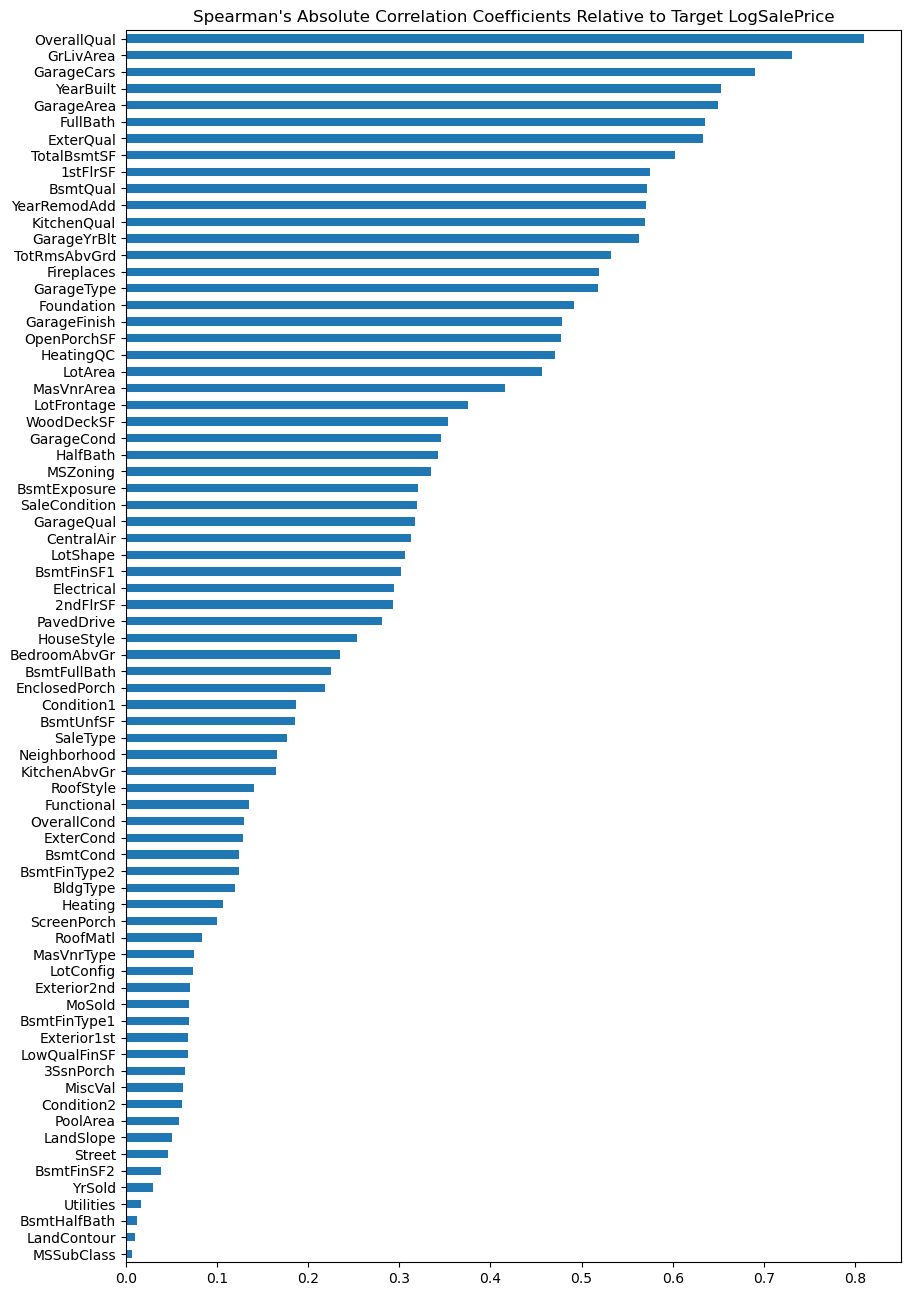

In [44]:
plt.title("Spearman's Absolute Correlation Coefficients Relative to Target LogSalePrice")
spearman_corr_coefs.abs().sort_values().plot(kind='barh',figsize=(10,16))

In [45]:
# useful to integrate drop features into pipeline
from sklearn.base import BaseEstimator, TransformerMixin
class ColumnDropperTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y):
        return self
    
    def transform(self, X, y=None):
        return X.drop(self.columns, axis=1)
    

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [47]:
oh_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
std_scaler = StandardScaler()
lin_reg_mdl = LinearRegression(n_jobs=3)

In [48]:
column_dropper = ColumnDropperTransformer(feature_poorly_correlated_to_target_to_drop)

In [49]:
categ_features_after_drop = list(set(non_numeric_columns) - set(feature_poorly_correlated_to_target_to_drop))
num_features_after_drop = list(set(numeric_columns) - set(feature_poorly_correlated_to_target_to_drop))

transformer = ColumnTransformer([('Categorical Features',oh_encoder, categ_features_after_drop),
                                 ('Numerical Features', std_scaler, num_features_after_drop)],
                                n_jobs=3)

In [50]:
pipe = Pipeline([("dropcolumns", column_dropper),
                 ("preprocessing", transformer),
                 ("regression", lin_reg_mdl)],verbose=True) 

In [51]:
abs(cross_val_score(pipe, X_train, y_train, n_jobs=3, scoring = 'neg_root_mean_squared_error', verbose=2, cv=5).mean())

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.1s finished


29950336548.687725

- Error just exploded, shitty choice

### 3. Mutual Information Gain

In [52]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [53]:
mutual_info_selector = SelectKBest(score_func=mutual_info_regression, k=30)

In [54]:
mutual_info_selector.fit(X_train_enc, y_train)

SelectKBest(k=30,
            score_func=<function mutual_info_regression at 0x000001F15FE715A0>)

In [55]:
features_to_drop_mutual_info =  X_train_enc.columns[~mutual_info_selector.get_support()]
features_to_drop_mutual_info

Index(['Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallCond', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'MasVnrArea',
       'ExterCond', 'BsmtCond', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinSF2',
       'BsmtUnfSF', 'Heating', 'CentralAir', 'Electrical', 'LowQualFinSF',
       'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition'],
      dtype='object')

<Axes: >

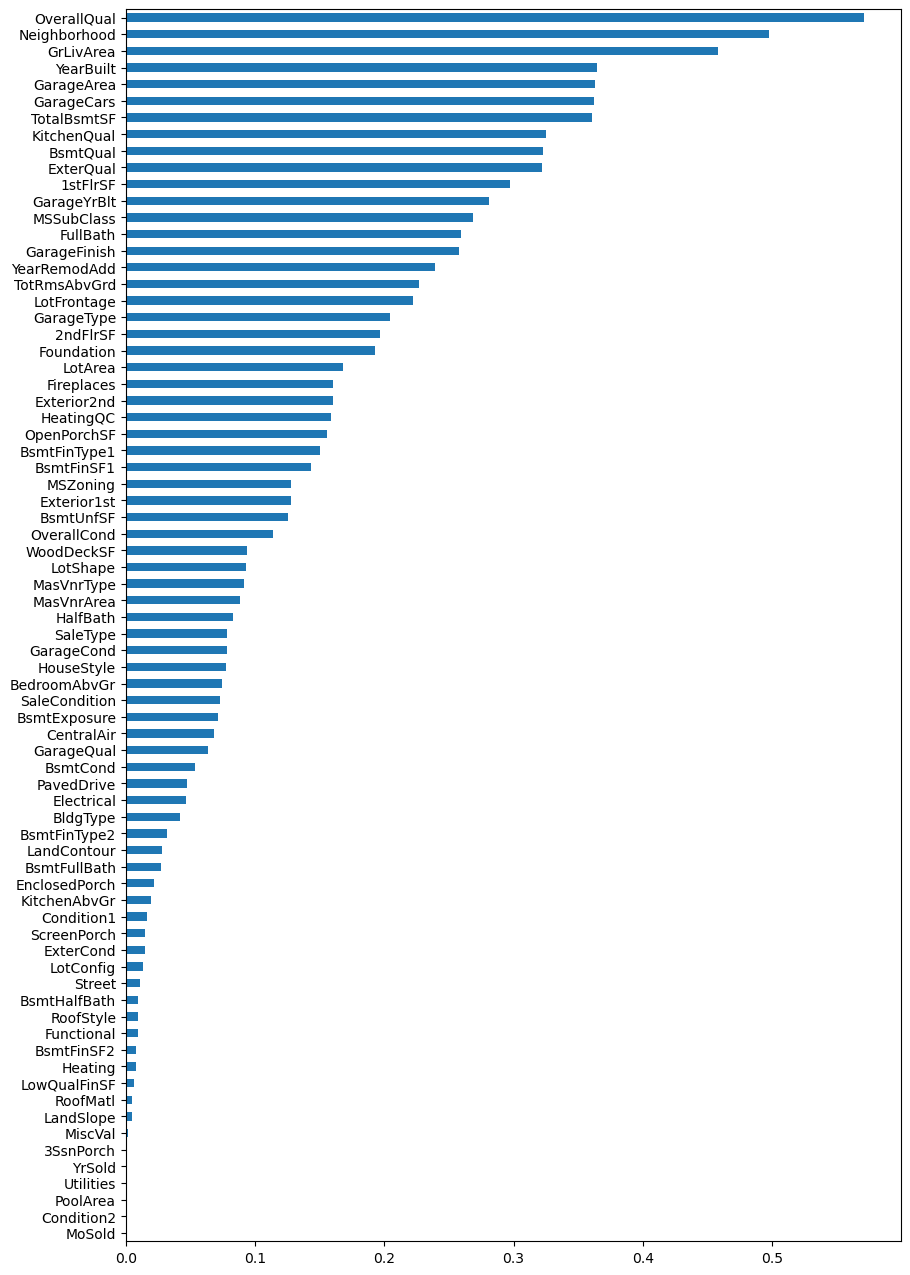

In [56]:
pd.Series(mutual_info_selector.scores_, index= mutual_info_selector.feature_names_in_).sort_values().plot(kind='barh',figsize=(10,16))

In [57]:
column_dropper = ColumnDropperTransformer(features_to_drop_mutual_info)

In [58]:
categ_features_after_drop = list(set(non_numeric_columns) - set(features_to_drop_mutual_info))
num_features_after_drop = list(set(numeric_columns) - set(features_to_drop_mutual_info))

transformer = ColumnTransformer([('Categorical Features',oh_encoder, categ_features_after_drop),
                                 ('Numerical Features', std_scaler, num_features_after_drop)],
                                n_jobs=3)

In [59]:
pipe = Pipeline([("dropcolumns", column_dropper),
                 ("preprocessing", transformer),
                 ("regression", lin_reg_mdl)],verbose=True) 

In [60]:
abs(cross_val_score(pipe, X_train, y_train, n_jobs=3, scoring = 'neg_root_mean_squared_error', verbose=2, cv=5).mean())

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.1s finished


0.1530153759438812

- By dropping 54 features according to mutual information method we were able to improve the model from baseline (~0.183) to (~0.155)

### 4. ANOVA test

In [61]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import f_regression

In [62]:
f_test_selector = SelectKBest(score_func=f_regression, k=20)

In [63]:
dummies = pd.get_dummies(data=X_train[non_numeric_columns], drop_first=True)
X_train_linear = X_train[numeric_columns].merge(dummies, left_index=True, right_index=True)
X_train_linear.shape

(1460, 242)

In [65]:
f_test_selector.fit(X_train_linear, y_train)

SelectKBest(k=20, score_func=<function f_regression at 0x000001F16050DEA0>)

In [66]:
features_to_drop_f_test = X_train_linear.columns[~f_test_selector.get_support()]
features_to_drop_f_test.shape

(222,)

<Axes: >

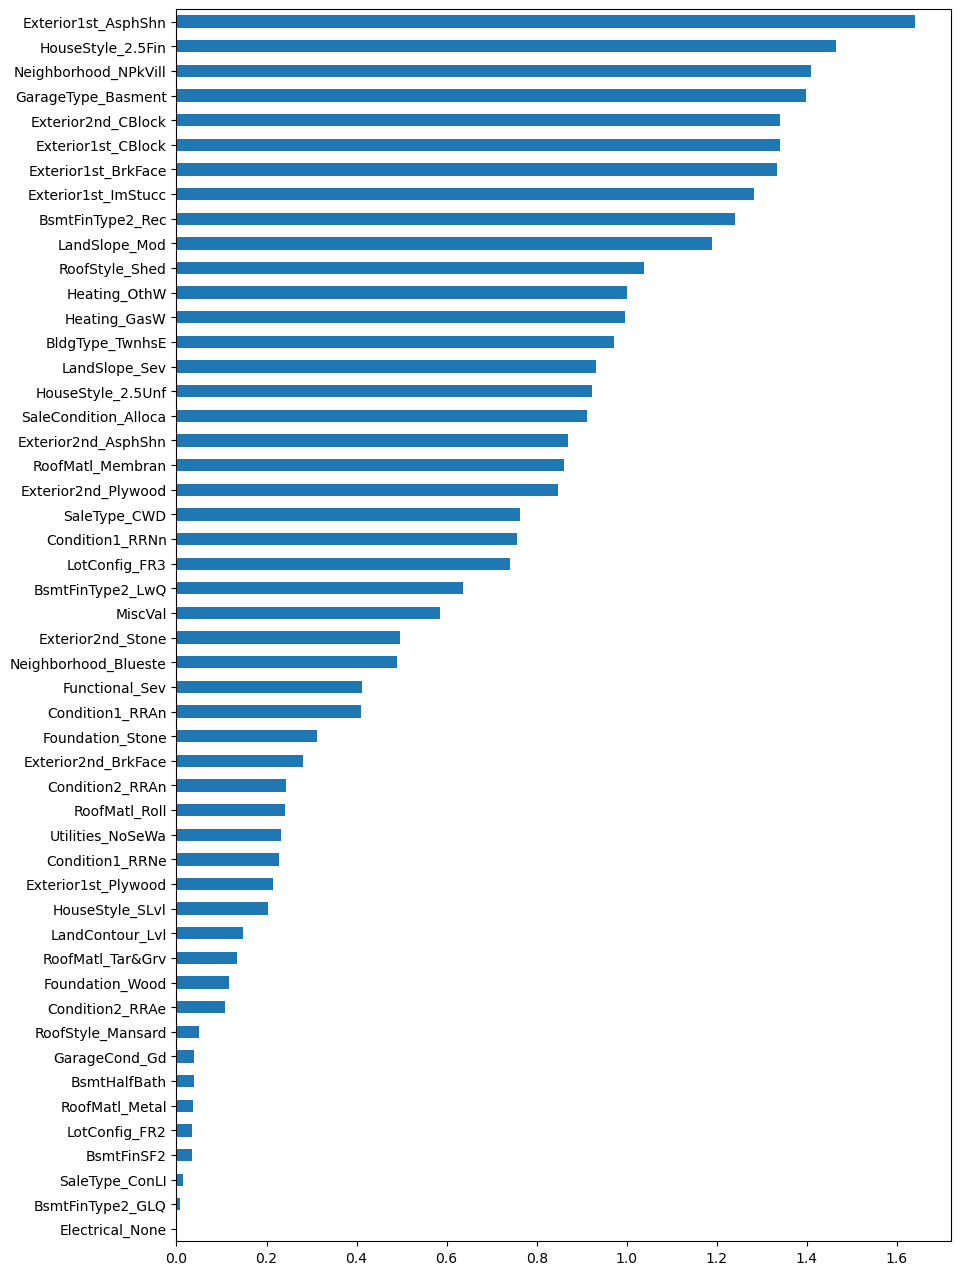

In [67]:
pd.Series(f_test_selector.scores_, index= f_test_selector.feature_names_in_).sort_values()[:50].plot(kind='barh',figsize=(10,16))

In [109]:
f_test_selector = SelectKBest(score_func=f_regression, k=70)

In [110]:
transformer = ColumnTransformer([('Categorical Features',oh_encoder, non_numeric_columns),
                                 ('Numerical Features', std_scaler, numeric_columns)],
                                n_jobs=3)

In [111]:
pipe = Pipeline([("preprocessing", transformer),
                 ("Select K Best F-Test", f_test_selector),
                 ("regression", lin_reg_mdl)],verbose=True) 

In [112]:
abs(cross_val_score(pipe, X_train, y_train, n_jobs=3, scoring = 'neg_root_mean_squared_error', verbose=2, cv=5, error_score='raise').mean())

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.1s finished


0.15732600301312552

- By filtering the 70 features (out of ~240 linearized features) we were able to obtain some level of improvement in model performance, still bellow the Information Gain filtering 

### 5. Random Forest Feature Importance - Embedded Methods

In [285]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectFromModel

In [286]:
rf_mdl = RandomForestRegressor(
    n_estimators=100,
    n_jobs=3,
    random_state=0)

In [287]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=99)
pre_fs_transformer = ColumnTransformer([("ordinal_encoding", encoder, non_numeric_columns)],remainder='passthrough', n_jobs=3)

In [288]:
selector_mdl = SelectFromModel(rf_mdl,threshold='median')

In [289]:
def get_categoric_mask(dataframe: pd.DataFrame, selector_model: SelectFromModel):
    return (dataframe.columns.isin(non_numeric_columns)) & (selector_model.get_support())

In [290]:
def get_numeric_mask(dataframe: pd.DataFrame, selector_model: SelectFromModel):
    return (dataframe.columns.isin(numeric_columns)) & (selector_model.get_support())

In [293]:
feature_selection_pipe = Pipeline(steps=[("preprocessing", pre_fs_transformer),
                                         ("feature_selection", selector_mdl)])

In [294]:
feature_selection_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=3, remainder='passthrough',
                                   transformers=[('ordinal_encoding',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99),
                                                  Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle'...
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestRegressor(n_jobs=3,
                                                                 random_state=0),
                                 threshold='median'))])

In [301]:
selected_features = pd.Series(feature_selection_pipe.get_feature_names_out())
categ_mask = selected_features.str.startswith("ordinal_encoding__")
numeric_mask = selected_features.str.startswith("remainder__")

In [303]:
# Sanity check whether any feature was left
categ_mask.sum() + numeric_mask.sum() - selected_features.shape[0], selected_features.shape[0]

(0, 37)

In [304]:
oh_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
std_scaler = StandardScaler()

In [320]:
transformer = ColumnTransformer([("onehot", oh_encoder, selected_features[categ_mask]),
                                 ("scaler", std_scaler, selected_features[numeric_mask])],
                                remainder='passthrough', n_jobs=3)

In [306]:
lin_reg_mdl = LinearRegression(n_jobs=3)

In [321]:
pipe = Pipeline(steps=[("preprocessing", transformer),
                       ("regression", lin_reg_mdl)])

In [316]:
def get_filtered_features(X, y, fitted_fs_pipe):
    X_new = pd.DataFrame(fitted_fs_pipe.transform(X), columns=fitted_fs_pipe.get_feature_names_out())
    y_new = y.copy()
    return X_new, y_new

In [318]:
X_train_filtered, y_train_filtered = get_filtered_features(X_train, y_train, feature_selection_pipe)
X_train_filtered

,ordinal_encoding__MSZoning,ordinal_encoding__Neighborhood,ordinal_encoding__Exterior1st,ordinal_encoding__ExterCond,ordinal_encoding__BsmtQual,ordinal_encoding__BsmtExposure,ordinal_encoding__BsmtFinType1,ordinal_encoding__CentralAir,ordinal_encoding__KitchenQual,ordinal_encoding__GarageType,...,remainder__TotRmsAbvGrd,remainder__Fireplaces,remainder__GarageYrBlt,remainder__GarageCars,remainder__GarageArea,remainder__WoodDeckSF,remainder__OpenPorchSF,remainder__EnclosedPorch,remainder__MoSold,remainder__YrSold
0,3.0,5.0,12.0,4.0,2.0,3.0,2.0,1.0,2.0,1.0,...,8.0,0.0,2003.0,2.0,548.0,0.0,61.0,0.0,2.0,2008.0
1,3.0,24.0,8.0,4.0,2.0,1.0,0.0,1.0,3.0,1.0,...,6.0,1.0,1976.0,2.0,460.0,298.0,0.0,0.0,5.0,2007.0
2,3.0,5.0,12.0,4.0,2.0,2.0,2.0,1.0,2.0,1.0,...,6.0,1.0,2001.0,2.0,608.0,0.0,42.0,0.0,9.0,2008.0
3,3.0,6.0,13.0,4.0,4.0,3.0,0.0,1.0,2.0,5.0,...,7.0,1.0,1998.0,3.0,642.0,0.0,35.0,272.0,2.0,2006.0
4,3.0,15.0,12.0,4.0,2.0,0.0,2.0,1.0,2.0,1.0,...,9.0,1.0,2000.0,3.0,836.0,192.0,84.0,0.0,12.0,2008.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,3.0,8.0,12.0,4.0,2.0,3.0,6.0,1.0,3.0,1.0,...,7.0,1.0,1999.0,2.0,460.0,0.0,40.0,0.0,8.0,2007.0
1456,3.0,14.0,9.0,4.0,2.0,3.0,0.0,1.0,3.0,1.0,...,7.0,2.0,1978.0,2.0,500.0,349.0,0.0,0.0,2.0,2010.0
1457,3.0,6.0,5.0,2.0,4.0,3.0,2.0,1.0,2.0,1.0,...,9.0,2.0,1941.0,1.0,252.0,0.0,60.0,0.0,5.0,2010.0
1458,3.0,12.0,8.0,4.0,4.0,2.0,2.0,1.0,2.0,1.0,...,5.0,0.0,1950.0,1.0,240.0,366.0,0.0,112.0,4.0,2010.0


In [322]:
abs(cross_val_score(pipe, X_train_filtered, y_train_filtered, n_jobs=3, scoring = 'neg_root_mean_squared_error', verbose=2, cv=5, error_score='raise').mean())

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:    2.2s remaining:    1.5s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    2.4s finished


13889790845.33254

- RMSE error just exploded....

In [326]:
rf_pipe = Pipeline([("preprocessing", pre_fs_transformer),("regression", rf_mdl)])

In [331]:
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=3, remainder='passthrough',
                                   transformers=[('ordinal_encoding',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99),
                                                  Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle'...
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('regression',
                 RandomForestRegressor(n_jobs=3, random_state=0))])

# of featues:  74


<Axes: title={'center': 'Feature selection: importances above median (37 out of 74)'}>

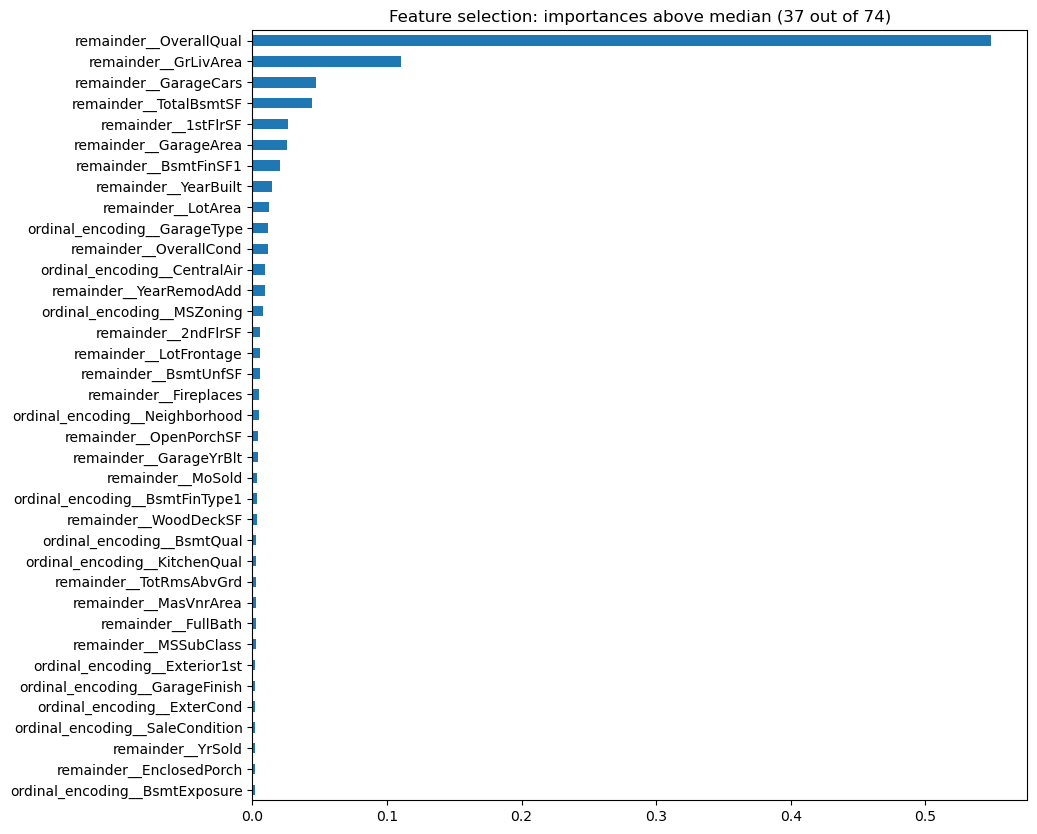

In [344]:
feature_importances = pd.Series(rf_pipe.steps[1][1].feature_importances_, index=rf_pipe.steps[0][1].get_feature_names_out())
print("# of featues: ", len(feature_importances))
plt.title(f"Feature selection: importances above median ({(feature_importances > feature_importances.median()).sum()} out of {len(feature_importances)})")
feature_importances[feature_importances > feature_importances.median()].sort_values().plot(kind='barh', figsize=(10,10))

In [329]:
from sklearn.metrics import mean_squared_error

In [367]:
selected_features = feature_importances[feature_importances > feature_importances.quantile(0.25)].sort_values(ascending=False).index
print(selected_features)

Index(['remainder__OverallQual', 'remainder__GrLivArea',
       'remainder__GarageCars', 'remainder__TotalBsmtSF',
       'remainder__1stFlrSF', 'remainder__GarageArea', 'remainder__BsmtFinSF1',
       'remainder__YearBuilt', 'remainder__LotArea',
       'ordinal_encoding__GarageType', 'remainder__OverallCond',
       'ordinal_encoding__CentralAir', 'remainder__YearRemodAdd',
       'ordinal_encoding__MSZoning', 'remainder__2ndFlrSF',
       'remainder__LotFrontage', 'remainder__BsmtUnfSF',
       'remainder__Fireplaces', 'ordinal_encoding__Neighborhood',
       'remainder__OpenPorchSF', 'remainder__GarageYrBlt', 'remainder__MoSold',
       'ordinal_encoding__BsmtFinType1', 'remainder__WoodDeckSF',
       'ordinal_encoding__BsmtQual', 'ordinal_encoding__KitchenQual',
       'remainder__TotRmsAbvGrd', 'remainder__MasVnrArea',
       'remainder__FullBath', 'remainder__MSSubClass',
       'ordinal_encoding__Exterior1st', 'ordinal_encoding__GarageFinish',
       'ordinal_encoding__ExterCon

In [368]:
numeric_columns = [feature[11:] for feature in selected_features if feature.startswith("remainder_")]
categ_columns = [feature[18:] for feature in selected_features if feature.startswith("ordinal_encoding__")]
column_transformer_lin_reg = ColumnTransformer([("onehot", OneHotEncoder(drop='first',handle_unknown='ignore'), categ_columns),
                                                ("scale", StandardScaler(), numeric_columns)],
                                               n_jobs=3)
pipe_lin_reg = Pipeline(steps=[("preprocessing", column_transformer_lin_reg),("regression", LinearRegression(n_jobs=3))])

In [369]:
X1, X2, y1, y2 = train_test_split(X_train[numeric_columns+categ_columns], y_train, test_size=0.3, random_state=0)

In [370]:
pipe_lin_reg.fit(X1,y1)
mean_squared_error(y2, pipe_lin_reg.predict(X2), squared=True)

0.028569481968776907

In [373]:
abs(cross_val_score(
    pipe_lin_reg, 
    X_train[numeric_columns+categ_columns], 
    y_train, 
    scoring= 'neg_root_mean_squared_error', cv=5, 
    n_jobs=3, 
    error_score='raise').mean())

0.14658284828508203

- I screwed the last pipeline, performance seems better in this case

### 6. Recursive Feature Elimination

In [382]:
from sklearn.feature_selection import RFE

In [383]:
rf_mdl = RandomForestRegressor(
    n_estimators=100,
    n_jobs=3,
    random_state=0)

In [434]:
selector_rfe = RFE(rf_mdl, n_features_to_select=55,verbose=2)

In [435]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=99)
pre_fs_transformer = ColumnTransformer([("ordinal_encoding", encoder, non_numeric_columns)],remainder='passthrough', n_jobs=3)

In [436]:
feature_selection_pipe = Pipeline(steps=[("preprocessing", pre_fs_transformer),
                                         ("feature_selection", selector_rfe)])

In [437]:
feature_selection_pipe.fit(X_train, y_train)

Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=3, remainder='passthrough',
                                   transformers=[('ordinal_encoding',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99),
                                                  Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle'...
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('feature_selection',
                 RFE(estimator=RandomForestRegressor(n_jobs=3, random_state=0),
                     n_features_to_select=55, verbose=2))])

In [438]:
selected_features = feature_selection_pipe.get_feature_names_out()
# selected_features = ["remainder__" + feature for feature in X_train.select_dtypes(include=numerics).columns] + \
#                     ["ordinal_encoding__" + feature for feature in X_train.select_dtypes(exclude=numerics).columns]
len(selected_features)

55

In [439]:
numeric_columns = [feature[11:] for feature in selected_features if feature.startswith("remainder_")]
categ_columns = [feature[18:] for feature in selected_features if feature.startswith("ordinal_encoding__")]
column_transformer_lin_reg = ColumnTransformer([("onehot", OneHotEncoder(drop='first',handle_unknown='ignore'), categ_columns),
                                                ("scale", StandardScaler(), numeric_columns)],
                                               n_jobs=3)
pipe_lin_reg = Pipeline(steps=[("preprocessing", column_transformer_lin_reg),("regression", LinearRegression(n_jobs=3))])

In [440]:
abs(cross_val_score(
    pipe_lin_reg, 
    X_train[numeric_columns+categ_columns], 
    y_train, 
    scoring= 'neg_root_mean_squared_error', cv=5, 
    n_jobs=3, 
    error_score='raise').mean())

0.14658313894271763

# Train models
- We are using the columns subset on the RFE feature selection method
- In this regression, we are to use / test the following methods
  - Linear Regression
  - Lasso Regression
  - Ridge Regression
  - RandomForest Regression
  - kNNeighobors Regression

In [458]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler

In [450]:
numeric_columns = [feature[11:] for feature in selected_features if feature.startswith("remainder_")]
categ_columns = [feature[18:] for feature in selected_features if feature.startswith("ordinal_encoding__")]

In [451]:
X_train_fs = X_train[numeric_columns+categ_columns]

In [452]:
column_transformer_lin_reg = ColumnTransformer([("onehot", OneHotEncoder(drop='first',handle_unknown='ignore'), categ_columns),
                                                ("scale", StandardScaler(), numeric_columns)],
                                               n_jobs=3)

In [453]:
lin_reg_pipe = Pipeline([("preprocessing",column_transformer_lin_reg),
                         ("regression", LinearRegression(n_jobs=3))])

In [454]:
lasso_reg_pipe = Pipeline([("preprocessing",column_transformer_lin_reg),
                           ("regression", Lasso(alpha=1.0, random_state=0))])

In [455]:
ridge_reg_pipe = Pipeline([("preprocessing",column_transformer_lin_reg),
                           ("regression", Ridge(alpha=1.0, random_state=0))])

In [459]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=99)
rf_preprocessing = ColumnTransformer([("encode", encoder, categ_columns)],remainder='passthrough', n_jobs=3)

rand_forest_pipe = Pipeline([("preprocessing",rf_preprocessing),
                          ("regression", RandomForestRegressor(n_estimators=100, n_jobs=3, random_state=0))])

In [460]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=99)
scaler = MinMaxScaler()
knn_preprocessing = ColumnTransformer([("encode", encoder, categ_columns),
                                       ("scale", scaler, numeric_columns)],remainder='passthrough', n_jobs=3)

knn_pipe = Pipeline([("preprocessing",knn_preprocessing),
                     ("regression", KNeighborsRegressor(n_neighbors=5, n_jobs=3))])

In [463]:
models = [("Linear Regression", lin_reg_pipe),
          ("Lasso Regression", lasso_reg_pipe),
          ("Ridge Regression", ridge_reg_pipe),
          ("Random Forest Regression", rand_forest_pipe),
          ("kNN Regression", knn_pipe),]

In [462]:
from sklearn.model_selection import cross_val_score

In [464]:
model_results = []

for model_name, model in models:
    scores = cross_val_score(model, X_train_fs, y_train, scoring = 'neg_root_mean_squared_error', cv = 5, n_jobs=3, error_score='raise')
    result_tup = (model_name, abs(scores.mean()), scores)
    model_results.append(result_tup)
    print(result_tup)

('Linear Regression', 0.14658313894271763, array([-0.12170098, -0.1541452 , -0.13880636, -0.13186964, -0.18639351]))
('Lasso Regression', 0.3992282792085989, array([-0.3867785 , -0.4251402 , -0.40997109, -0.38299932, -0.39125229]))
('Ridge Regression', 0.1433626352637824, array([-0.11734869, -0.15185196, -0.13386598, -0.12791741, -0.18582912]))
('Random Forest Regression', 0.14303311750217929, array([-0.13579903, -0.15712092, -0.14551708, -0.12938671, -0.14734185]))
('kNN Regression', 0.2368474543743757, array([-0.23783983, -0.23795511, -0.24024928, -0.24508049, -0.22311257]))


In [470]:
pd.Series([result[1] for result in model_results], index=[result[0] for result in model_results]).sort_values()

Random Forest Regression    0.143033
Ridge Regression            0.143363
Linear Regression           0.146583
kNN Regression              0.236847
Lasso Regression            0.399228
dtype: float64

- Random FOrest, Ridge and Linear Regressions seem to perfom well...
- We will use a simple mean of predicted values from the 3 models in order to predict our end value

In [471]:
selected_models = [("Linear Regression", lin_reg_pipe),
                   ("Ridge Regression", ridge_reg_pipe),
                   ("Random Forest Regression", rand_forest_pipe)]

In [473]:
X_test_fs = X_test[numeric_columns+categ_columns]

In [475]:
predictions = []
for model_name, model in selected_models:
    model.fit(X_train_fs, y_train)
    predict = np.exp(model.predict(X_test_fs))
    predict_tup = (model_name, predict)
    predictions.append(predict_tup)
    print(model_name, " ... complete")

Linear Regression  ... complete
Ridge Regression  ... complete
Random Forest Regression  ... complete


In [478]:
predictions_dict = dict(predictions)
predictions_dict

{'Linear Regression': array([111793.88164014, 148132.45777822, 173333.13513139, ...,
        159827.49022361, 111623.54147953, 223176.03894149]),
 'Ridge Regression': array([109613.97178397, 148977.61569994, 172379.23187669, ...,
        160004.97207966, 112190.61296421, 222823.15433312]),
 'Random Forest Regression': array([124347.53074526, 151740.76489766, 169610.0591792 , ...,
        156203.1800023 , 112435.45861762, 235392.70671583])}

In [482]:
avg_pred = (predictions_dict["Linear Regression"] + predictions_dict["Ridge Regression"] + predictions_dict["Random Forest Regression"]) / 3

In [483]:
avg_pred.shape

(1459,)

<Axes: ylabel='Count'>

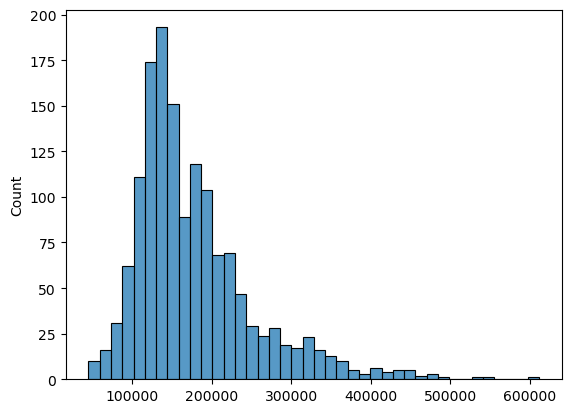

In [485]:
sns.histplot(avg_pred)

In [497]:
submission_df = pd.DataFrame(test_df["Id"])
submission_df["SalePrice"] = avg_pred

In [499]:
submission_df.to_csv("./outputs/submission.csv", index=False)

In [501]:
!head -5 ./outputs/submission.csv

Id,SalePrice
1461,115251.7947231232
1462,149616.94612527115
1463,171774.14206242329
1464,189189.9995375521


In [502]:
!wc -l ./outputs/submission.csv

1460 ./outputs/submission.csv
